In [7]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import nltk
import spacy
#from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import en_core_web_md
text_to_nlp = spacy.load('en_core_web_md')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

INVISIBLE_CHARS = re.compile(r'[\u200B\u200C\u200D\u200E\u200F\uFEFF\u00A0]')
URLS = re.compile(r'https?://\S+|www\.\S+')
EMOJIS = re.compile("["
                    u"\U0001F600-\U0001F64F"
                    u"\U0001F300-\U0001F5FF"
                    u"\U0001F680-\U0001F6FF"
                    u"\U0001F1E0-\U0001F1FF"
                    u"\U00002700-\U000027BF"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)

REMOVE_PUNCT_DIGITS = str.maketrans('', '', string.punctuation + string.digits)
CUSTOM_STOPWORDS = {
    '|', '=', '1', '5', '2018', 'usd', 'price', 'exchange',
    '€', '24', 'utc', 'en', 'high', 'low', 'volume'
}
BITCOIN_ALIASES = {'btc', 'bit', 'bitcoin', 'bitcoins', 'bit coin'}
OTHER_CRYPTO = {
    'eth', 'ethereum', 'xrp', 'bch', 'ltc', 'etc', 'ada', 'doge', 'shiba',
    'polkadot', 'dot', 'bnb', 'solana', 'trx', 'eos', 'neo', 'iota', 'monero',
    'dash', 'zec', 'vechain', 'theta', 'stellar', 'xlm', 'avax', 'algo',
    'matic', 'near', 'icp', 'aptos', 'apt', 'kaspa', 'kas'
}

import warnings
warnings.filterwarnings('ignore')

In [8]:
def clean_text(text):
    if not isinstance(text, str) or not text:
        return ''
    text = unicodedata.normalize('NFKC', text)
    text = INVISIBLE_CHARS.sub('', text)
    text = URLS.sub('', text)
    text = EMOJIS.sub('', text)
    text = text.lower()
    text = text.translate(REMOVE_PUNCT_DIGITS)
    tokens = text.split()

    has_bitcoin = False
    clean_tokens = []
    
    for token in tokens:
        if token in OTHER_CRYPTO or token in CUSTOM_STOPWORDS:
            continue
      
        if token in BITCOIN_ALIASES:
            if has_bitcoin:
                continue 
            else:
                #clean_tokens.append('bitcoin')
                has_bitcoin = True
        else:
            clean_tokens.append(token)

    return ' '.join(clean_tokens)

def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) and (token.lemma_ != '-PRON-') and (not token.is_punct):
            clean_tokens.append(token.lemma_)
    return clean_tokens

# Prices


In [11]:
df_SP2 = pd.read_csv("./Raw/SP500Price.csv")
df_BP2 = pd.read_csv("./Raw/BitcoinPrice.csv",sep=";")

df_BP2.drop(columns=['timeClose', 'timeHigh', 'timeLow','name','volume','marketCap','timestamp'], inplace=True)

df_SP2 = df_SP2.rename(columns={
    'Open': 'Open_S',
    'Close/Last': 'Close_S',
    'High': 'High_S',
    'Low': 'Low_S',
})

df_BP2 = df_BP2.rename(columns={
    'timeOpen': 'Date',
    'open': 'Open_B',
    'high': 'High_B',
    'low': 'Low_B',
    'close': 'Close_B',
})

df_SP2['Date'] = pd.to_datetime(df_SP2['Date'])
df_BP2['Date'] = pd.to_datetime(df_BP2['Date'])
df_BP2['Date'] = df_BP2['Date'].dt.tz_localize(None)

merged_prices = pd.merge(df_SP2, df_BP2, on='Date')

file_path = os.path.join('./Processed', 'combined_prices.csv')

merged_prices.to_csv(file_path, index=False)

print(df_BP2.tail)
print(df_SP2.tail)

<bound method NDFrame.tail of           Date        Open_B        High_B         Low_B       Close_B
0   2024-01-02  44187.139039  45899.706355  44176.950443  44957.970054
1   2024-01-01  42280.235276  44175.436053  42214.976755  44167.330214
2   2023-12-31  42152.098454  42860.937392  41998.255346  42265.185655
3   2023-12-30  42091.752644  42584.123640  41556.225992  42156.901150
4   2023-12-29  42614.643892  43124.325860  41424.060641  42099.402809
..         ...           ...           ...           ...           ...
395 2022-12-03  17090.098485  17116.040806  16888.140807  16908.236795
396 2022-12-02  16968.683261  17088.660409  16877.881596  17088.660409
397 2022-12-01  17168.002138  17197.497253  16888.387888  16967.133667
398 2022-11-30  16445.477489  17190.938273  16445.477489  17168.565548
399 2022-11-29  16217.639904  16522.257471  16139.396275  16444.983270

[400 rows x 5 columns]>
<bound method NDFrame.tail of            Date  Close_S   Open_S   High_S    Low_S
0    2025-0

In [9]:
df_SP = pd.read_csv("./Raw/SPX.csv")
df_BP = pd.read_csv("./Raw/BTC-USD.csv")

df_SP['Date'] = pd.to_datetime(df_SP['Date'])
df_BP['Date'] = pd.to_datetime(df_BP['Date'])

df_SP = df_SP.rename(columns={
    'Open': 'Open_S',
    'High': 'High_S',
    'Low': 'Low_S',
    'Close': 'Close_S',
    'Adj Close': 'Adj Close_S',
    'Volume': 'Volume_S'
})

df_BP = df_BP.rename(columns={
    'Open': 'Open_B',
    'High': 'High_B',
    'Low': 'Low_B',
    'Close': 'Close_B',
    'Adj Close': 'Adj Close_B',
    'Volume': 'Volume_B'
})

merged_prices = pd.merge(df_SP, df_BP, on='Date')

file_path = os.path.join('./Processed', 'combined_prices.csv')

merged_prices.to_csv(file_path, index=False)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1815 - val_loss: 0.2888
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1118 - val_loss: 0.1526
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0481 - val_loss: 0.0135
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - val_loss: 0.0225
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - val_loss: 0.0202
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0104
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0082
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0077
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 13/20


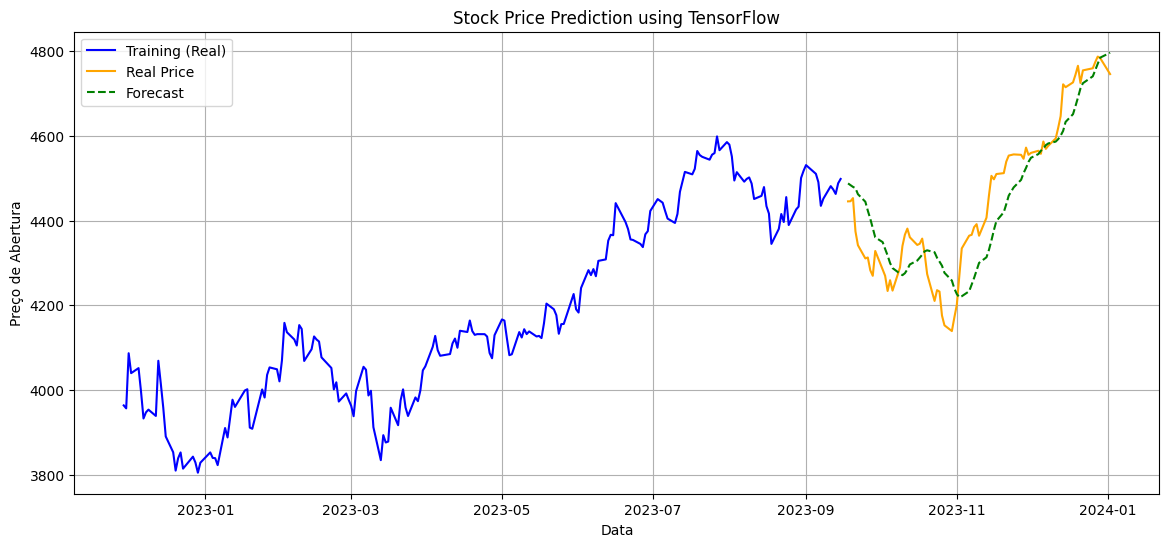

In [12]:
df = pd.read_csv('./Processed/combined_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[['Date', 'Open_S']].dropna()

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Open_S']])
df['Scaled'] = scaled

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df['Scaled'].values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(14, 6))
plt.plot(df['Date'].iloc[:len(X_train) + window_size],
         scaler.inverse_transform(df['Scaled'].values[:len(X_train) + window_size].reshape(-1, 1)), 
         label='Training (Real)', color='blue'
         )
plt.plot(df['Date'].iloc[-len(y_test_inv):], y_test_inv.ravel(), label='Real Price', color='orange')
plt.plot(df['Date'].iloc[-len(y_pred_inv):], y_pred_inv.ravel(), label='Forecast', color='green', linestyle='dashed')
plt.title('Stock Price Prediction using TensorFlow')
plt.xlabel('Data')
plt.ylabel('Preço de Abertura')
plt.legend()
plt.grid()
plt.show()

# Sentiment 

### Bitcoin

In [7]:
df_BS = pd.read_csv("./Raw/BitcoinSent.csv")

#clean dataframe
df_BS['Date'] = pd.to_datetime(df_BS['Date'], errors='coerce')
df_BS = df_BS[df_BS['Date'].notna()]
df_BS = df_BS[df_BS['text'].notna()]
df_BS = df_BS[df_BS['text'].apply(lambda x: isinstance(x, str))]
df_BS = df_BS[df_BS['Sentiment'].notna()]
df_BS = df_BS[df_BS['Sentiment'].isin(['Positive', 'Negative'])]
df_BS['Sentiment'] = df_BS['Sentiment'].map({'Positive': 1, 'Negative': 0})

df_BS.rename(columns={'text': 'body'}, inplace=True)

#sort in ascending date
df_BS = df_BS.sort_values(by='Date', ascending=True)
df_BS = df_BS.reset_index(drop=True)

#testing
df_BS.tail

<bound method NDFrame.tail of                Date                                               body  \
0        2014-09-18  #RDD / #BTC on the exchanges:\nCryptsy: 0.0000...   
1        2014-09-18  Current price: 418.77$ $BTCUSD $btc #bitcoin 2...   
2        2014-09-18  1 #BTC (#Bitcoin) quotes:\n$423.60/$424.80 #Bi...   
3        2014-09-18  In the last 10 mins, there were arb opps spann...   
4        2014-09-18  Be judicious, buy your Bitcoins at https://Bit...   
...             ...                                                ...   
18452496 2019-11-23  €400 million investment in Blockchain and AI t...   
18452497 2019-11-23  BTC/USD | $BTCUSD | $BTC $USD\n\nBitcoin Outlo...   
18452498 2019-11-23  BTC\n\n長期的目線\n\n現在のトライアングル収束までに要した期間と人々の関心から、\...   
18452499 2019-11-23  SPECIAL DEAL TO ANYONE HAS CASH APP OR BITCOIN...   
18452500 2019-11-23  $BTC - an update on the longer term view for B...   

          Sentiment  
0                 0  
1                 0  
2              

In [8]:
#FOR VISUALIZATION - OTHER FILE
mask = (df_BS['Date'] >= '2018-01-07') & (df_BS['Date'] <= '2018-02-06')

visu_words = df_BS.loc[mask]
visu_words.drop(columns='Sentiment', inplace=True)
visu_words = visu_words.reset_index(drop=True)

visu_words = visu_words.groupby('Date').apply(lambda x: x.sample(n=min(len(x), 800))).reset_index(drop=True)

visu_words['body'] = visu_words['body'].apply(clean_text)
visu_words['body'] = visu_words['body'].apply(tokenize)

visu_words.tail
visu_words.to_pickle('visu_words.pkl')

In [9]:
#sample dataframe
sampled_BS = df_BS.groupby('Date').apply(lambda x: x.sample(n=min(len(x), 5))).reset_index(drop=True)

#clean every text
sampled_BS['body'] = sampled_BS['body'].apply(clean_text)

#apply tokenizer
sampled_BS['body'] = sampled_BS['body'].apply(tokenize)

#join dates and merge text
test = sampled_BS
test['body_str'] = test['body'].apply(lambda tokens: ' '.join(tokens))

test = test.groupby('Date').agg({
    'body': list,
    'body_str': lambda texts: ' '.join(texts),
    'Sentiment': 'mean'
}).reset_index()


file_path = os.path.join('./Processed', 'btc_nlp_test.csv')
test.to_csv(file_path, index=False)

### Stock

In [10]:
df_SS = pd.read_csv("./Raw/StockSent.csv")

df_SS['post_date'] = pd.to_datetime(df_SS['post_date'], unit='s')
df_SS['post_date'] = df_SS['post_date'].dt.strftime('%Y-%m-%d')
df_SS.rename(columns={'post_date': 'Date'}, inplace=True)

df_SS.drop(columns=['tweet_id', 'writer', 'comment_num', 'retweet_num', 'like_num'], inplace=True)

df_SS.tail

<bound method NDFrame.tail of                Date                                               body
0        2015-01-01  lx21 made $10,008  on $AAPL -Check it out! htt...
1        2015-01-01  Insanity of today weirdo massive selling. $aap...
2        2015-01-01  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...
3        2015-01-01  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...
4        2015-01-01  Swing Trading: Up To 8.91% Return In 14 Days h...
...             ...                                                ...
3717959  2019-12-31  That $SPY $SPX puuump in the last hour was the...
3717960  2019-12-31  In 2020 I may start Tweeting out positive news...
3717961  2019-12-31  Patiently Waiting for the no twitter sitter tw...
3717962  2019-12-31  I don't discriminate. I own both $aapl and $ms...
3717963  2019-12-31  $AAPL #patent 10,522,475 Vertical interconnect...

[3717964 rows x 2 columns]>

In [11]:
#sample dataframe
sampled_SS = df_SS.groupby('Date').apply(lambda x: x.sample(n=min(len(x), 5))).reset_index(drop=True)

#clean every text
sampled_SS['body'] = sampled_SS['body'].apply(clean_text)

#apply tokenizer
sampled_SS['body'] = sampled_SS['body'].apply(tokenize)

#join dates and merge text
testS = sampled_SS
testS['body_str'] = testS['body'].apply(lambda tokens: ' '.join(tokens))

testS = testS.groupby('Date').agg({
    'body': list,
    'body_str': lambda texts: ' '.join(texts),
}).reset_index()


file_path = os.path.join('./Processed', 'stock_nlp_test.csv')
testS.to_csv(file_path, index=False)